# **Data Modelling & Evalutaion**

## Objectives

* This notebook will address business requirtement 2: Determining whether a given leaf is infected with powdery mildew or not

## Inputs

* inputs/cherry_leaves_dataset/cherry-leaves/train
* inputs/cherry_leaves_dataset/cherry-leaves/test
* inputs/cherry_leaves_dataset/cherry-leaves/validation
* Image shape embeddings 

## Outputs

* Plot in of image distribution in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

## Additional Comments

* In this notebook we will develop the ML model and train it using the train and validation sets. We will then evaluate using the test set to determine if business requirement 2 has been met.



---

## Import packages

In [64]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

---

# Change working directory

The working directory must be changed from its current folder to its parent folder

In [65]:
cwd=os.getcwd()

In [66]:
os.chdir('/workspace/CherryPicker')
print('You set a new working directory')

You set a new working directory


Confirm the new current directory

In [67]:
work_dir = os.getcwd()
work_dir

'/workspace/CherryPicker'

---

## Set input directories

Set paths for train, test and validation sets

In [68]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [69]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set Labels

In [70]:
# Set the labels for the images
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'powdery_mildew']


## Set image shape

In [72]:
# Import saved image shape embedding
import joblib
version = 'v2'
image_shape = (160, 160, 1)
image_shape
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape_grayscale.pkl")

['outputs/v2/image_shape_grayscale.pkl']

---

# Number of images in each set

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




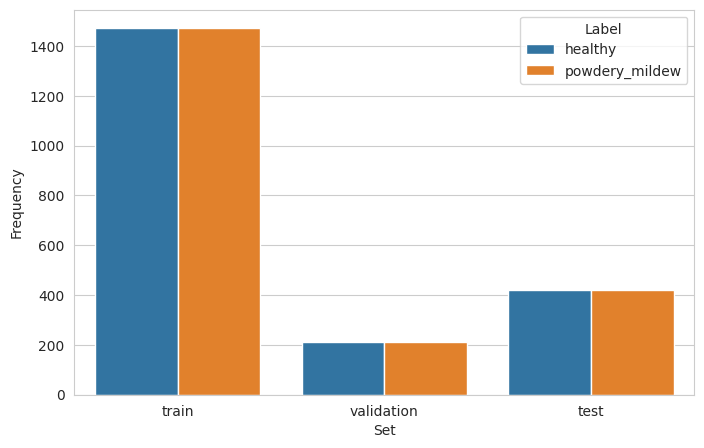

In [73]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Frequency': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)
 
print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5)) 
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Data Augmentation

Import ImageDataGenerator

In [74]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialise ImageDataGenerator

In [75]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


### Augment Image sets

Train

In [76]:
batch_size = 20
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='grayscale',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Validation

In [77]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='grayscale',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Test

In [78]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='grayscale',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented Images

Train

(20, 160, 160, 1)


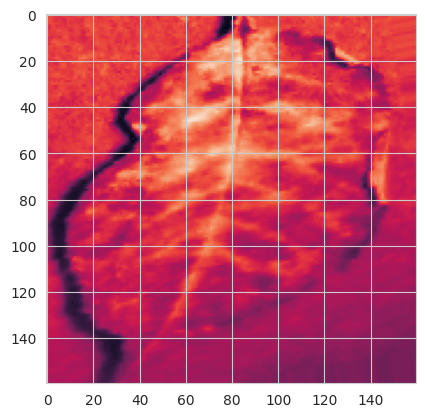

(20, 160, 160, 1)


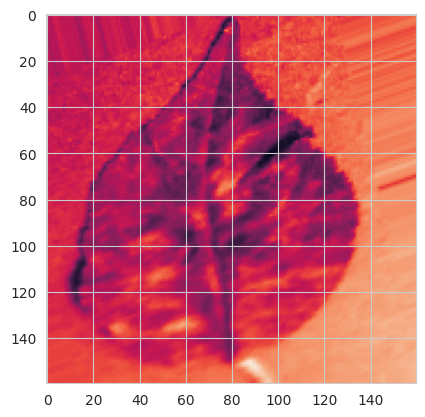

(20, 160, 160, 1)


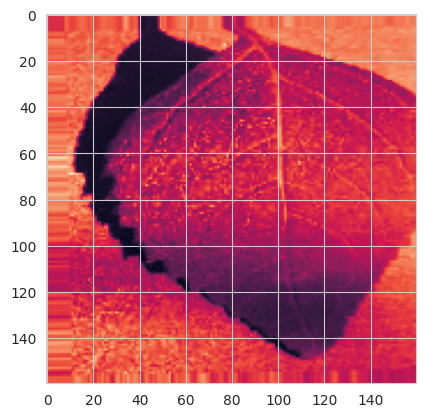

In [79]:
for _ in range(3):
    img, label = next(train_set)
    print(img.shape)
    plt.imshow(img[0])
    plt.show()


Validation

(20, 160, 160, 1)


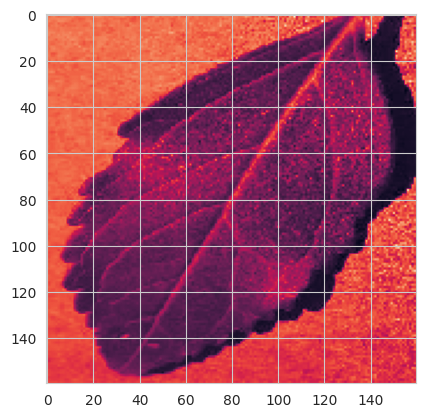

(20, 160, 160, 1)


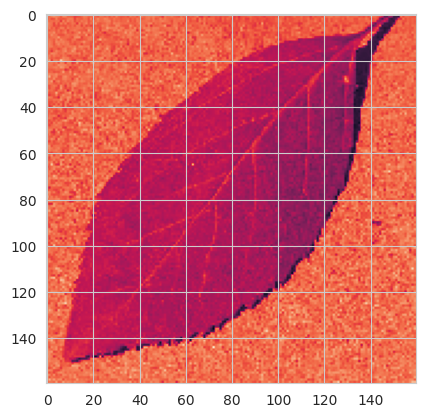

(20, 160, 160, 1)


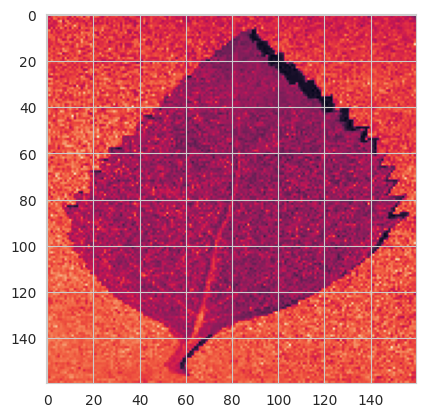

In [80]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

Test

(20, 160, 160, 1)


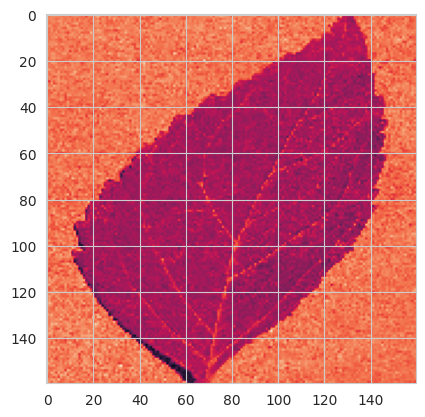

(20, 160, 160, 1)


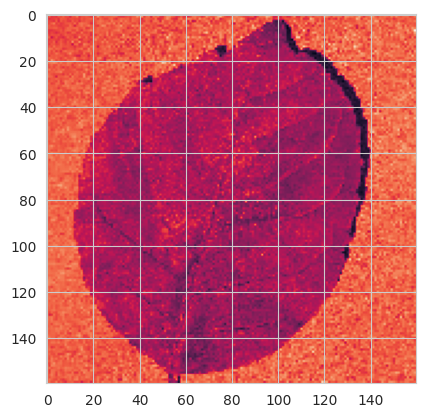

(20, 160, 160, 1)


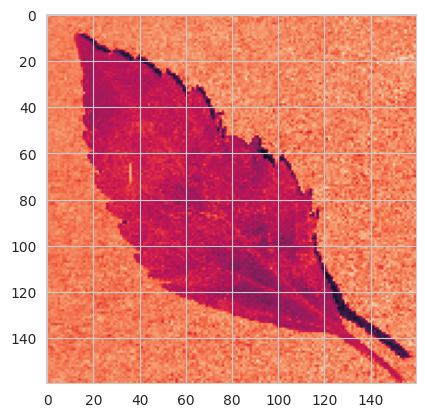

In [81]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [82]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v2/class_indices.pkl']

---

## ML Model Creation

### Import packages

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### Create model

In [84]:

def create_tf_model():
    """
    """
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())   
    
    model.add(Dense(128, activation='relu'))
    
    model.add(Dropout(0.5))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


### ML model summary

In [85]:
create_tf_model().summary()

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 158, 158, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,710,209 (10.34 MB)

 Trainable params: 2,710,209 (10.34 MB)

 Non-trainable params: 0 (0.00 B)

### Early Stopping

In [86]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit ML model

In [87]:
model = create_tf_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


Epoch 1/20


/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


147/147 ━━━━━━━━━━━━━━━━━━━━ 53s 351ms/step - accuracy: 0.6957 - loss: 0.5224 - val_accuracy: 0.8381 - val_loss: 0.5415
Epoch 2/20
  1/147 ━━━━━━━━━━━━━━━━━━━━ 42s 293ms/step - accuracy: 0.8000 - loss: 0.3101

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8000 - loss: 0.3101 - val_accuracy: 0.8690 - val_loss: 0.4417
Epoch 3/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 347ms/step - accuracy: 0.9546 - loss: 0.1382 - val_accuracy: 0.9643 - val_loss: 0.1421
Epoch 4/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.9667 - val_loss: 0.1426
Epoch 5/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 348ms/step - accuracy: 0.9673 - loss: 0.1025 - val_accuracy: 0.9571 - val_loss: 0.1520
Epoch 6/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 1.0000 - loss: 0.0448 - val_accuracy: 0.9643 - val_loss: 0.1258
Epoch 7/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 52s 353ms/step - accuracy: 0.9745 - loss: 0.0694 - val_accuracy: 0.9929 - val_loss: 0.0367
Epoch 8/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 1.0000 - loss: 0.0043 - val_accuracy: 0.9929 - val_loss: 0.0351
Epoch 9/20
147/147 ━━━━━━━━━━━━━━━━━━━━ 51s 349ms/step - accuracy: 0.9881 - loss: 0.0387 - val_accurac

### Save model

In [88]:
model.save('outputs/v2/powdery_mildew_model.h5')

---

# ML model Performance

### Learning Curve

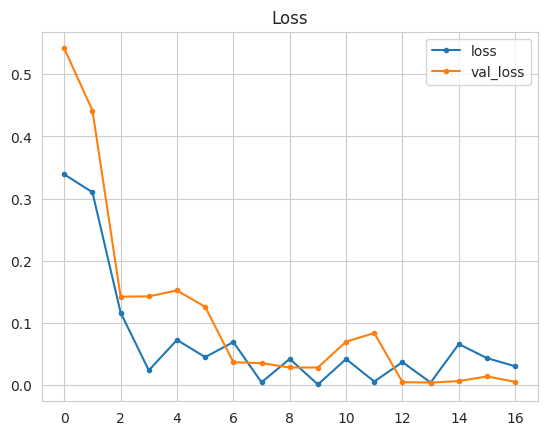

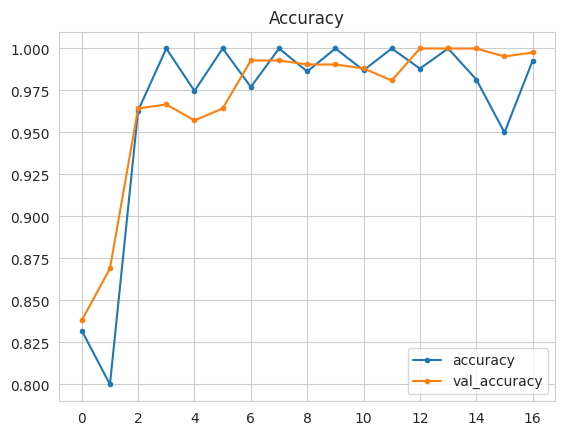

In [89]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=125)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=125)
plt.show()


### Model Evaluation

Load Model

In [90]:
from keras.models import load_model
model = load_model('outputs/v2/powdery_mildew_model.h5')

Evaluate on test set

In [91]:
evaluation = model.evaluate(test_set)

/workspace/.pip-modules/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9995 - loss: 0.0041


Save Evaluation pickle file

In [92]:
joblib.dump(value=evaluation,
            filename=f"outputs/v2/evaluation.pkl")


['outputs/v2/evaluation.pkl']

# Evaluate on new data

Use random image as PIL

Image shape: (160, 160), Image mode: L


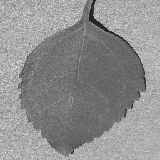

In [93]:
from tensorflow.keras.preprocessing import image

pointer = 45
label = labels[0]  

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=(160, 160, 1), color_mode='grayscale')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert image to array

In [94]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 160, 160, 1)


Predict Class probabilities

In [95]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
0.9999834441077837
healthy


---